## Read video tape with OpenCV2

In [11]:
import cv2
from os.path import join
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import numpy as np

In [2]:
VIDEO_FOLDER = 'data/CDF M17 VBALL - Voiron/'
VIDEO_NAME = 'Vb@ll - Voiron 1er Set 25-21.mkv'

src = join(VIDEO_FOLDER, VIDEO_NAME)
cap = cv2.VideoCapture(src)

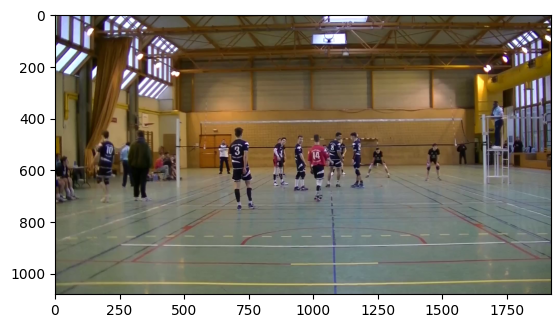

True


In [3]:
ret, frame = cap.read()
rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.show()
print(ret)

In [18]:
def read_video(src, limit_output_size=10, offset_between=0):
    """Read the video stored at path 'src' using cv2, return the list of the frames of the video.
    
    Each read frame is transformed to rgb format.
    <param limit_output_size> int : maximum number of frames to be returned
    <param offset_between> int : number of unselected frames between two selected frames
    """
    video_cap = cv2.VideoCapture(src)
    frames = []
    iter = 0
    offset = offset_between
    progress = tqdm(total=limit_output_size*offset_between)
    while video_cap.isOpened() and iter < limit_output_size:
        try:
            ret, frame = video_cap.read()
            if offset == 0:
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(rgb)
                iter += 1
                offset = offset_between
            else:
                offset -= 1
            progress.update(1)
        except ValueError as err:
            print('Frame loading failed : ', err)
            break
    print('Full output computed')
    return frames


#frames = read_video(src, limit_output_size=100, offset_between=10)
    

In [1]:
from video_processor import VideoProcessor

In [2]:
import os
VIDEO_FOLDER = 'data/CDF M17 VBALL - Voiron/'
VIDEO_NAME = 'Vb@ll - Voiron 1er Set 25-21.mkv'

src = os.path.join(VIDEO_FOLDER, VIDEO_NAME)

In [3]:
vid = VideoProcessor(src,limit_output_size=10)


Processing: 100%|██████████

Frames processing completed


In [4]:
vid.show_video()

In [4]:
def foreground_only(video_path):
    vid = cv2.VideoCapture(video_path)
    fgbg = cv2.createBackgroundSubtractorMOG2()
    
    bgSubList = []
    colored_frames = []
    for i in range(30):
        _, frame = vid.read()
        bgSubList.append(bg_subtract(frame,fgbg))
        colored_frames.append(frame)
    
    vid.release()
    cv2.destroyAllWindows()
    
    return bgSubList, colored_frames

def bg_subtract(frame, fgbg):
    	kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    	fgmask = fgbg.apply(frame)
    	fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)

        # Erosions, dilations, and median blur used to eliminate noisy single pixels and smooth contours
    	fgmask = cv2.erode(fgmask, kernel)
    	fgmask = cv2.erode(fgmask, kernel)
    	fgmask = cv2.erode(fgmask, kernel)
    	fgmask = cv2.dilate(fgmask, kernel)
    	fgmask = cv2.dilate(fgmask, kernel)
    	fgmask = cv2.dilate(fgmask, kernel)
    	fgmask = cv2.dilate(fgmask, kernel)
    	fgmask = cv2.dilate(fgmask, kernel)
    	fgmask = cv2.medianBlur(fgmask, 5)
    	fgmask = cv2.medianBlur(fgmask, 5)

    	return fgmask

In [5]:
def recolorize_frames(colored_frames, no_bg_frames):
    recolorized_frames = deepcopy(colored_frames)
    for i in range(len(colored_frames)):
        binary_mask = (no_bg_frames[i] == 0).astype(bool)
        recolorized_frames[i][binary_mask] = 0
    return recolorized_frames


In [57]:
src = 'data/serve.mp4'
no_bg_frames, colored_frames = foreground_only(src)
recolorized_frames = recolorize_frames(colored_frames, no_bg_frames)


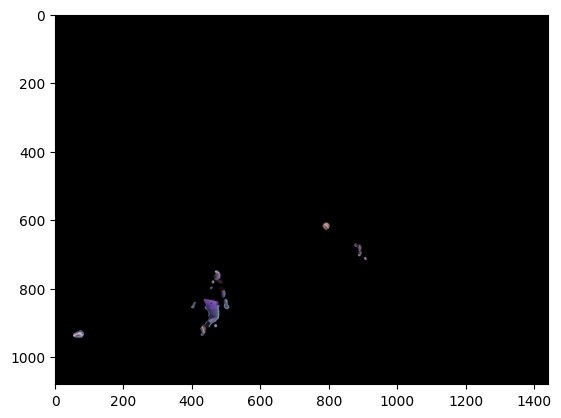

In [7]:
plt.imshow(recolorized_frames[15])

In [8]:
def remove_fg(colored_frames, no_bg_frames):
    bg_frames = deepcopy(colored_frames)
    for i in range(len(colored_frames)):
        binary_mask = (no_bg_frames[i] > 0).astype(bool)
        bg_frames[i][binary_mask] = 0
    return bg_frames[1:]
        

    

In [61]:
def create_background_aggregate(bg_frames):
    bg_agg = bg_frames[0]
    blackened_pixels = {}
    for k in range(len(bg_frames)):
        for i,j in np.argwhere(bg_frames[k].sum(axis=-1)==0):
            blackened_pixels[(k,i,j)]=True
            if k>0:
                if not(blackened_pixels.get((0,i,j))):
                    bg_agg[i,j]=0
        
    return bg_agg
    
        
    

In [71]:
def robust_background_detector(bg_frames,bg_agg):
    bg_agg = create_background_aggregate(bg_frames)
    only_bg = deepcopy(bg_agg)
    for i,j in np.argwhere(bg_agg.sum(axis=-1)==0):
        pixels_to_average = np.array([bg_frames[k][i,j] for k in range(1,len(bg_frames))])
        non_black_pixels = np.count_nonzero(pixels_to_average.sum(axis=-1))
        only_bg[i,j] = pixels_to_average.sum(axis=0)/non_black_pixels if non_black_pixels else 0
    return only_bg
        

In [62]:
bg_frames = remove_fg(colored_frames, no_bg_frames)
bg_agg = create_background_aggregate(bg_frames)

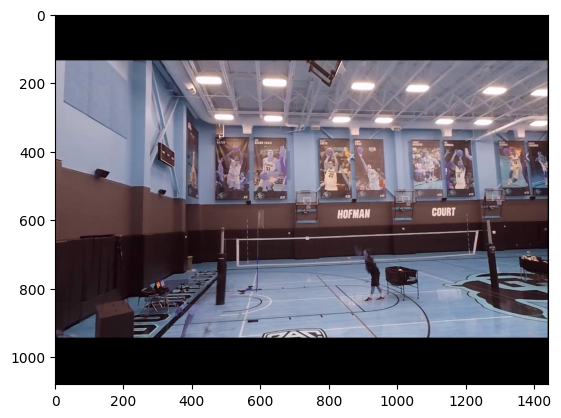

In [72]:
plt.imshow(robust_background_detector(bg_frames,bg_agg))

In [70]:
a=np.array([[1,2,3],[4,5,6]])
a.sum(axis=-1)

array([ 6, 15])